In [18]:
import mxnet as mx 
from importlib import import_module
import cv2
import matplotlib.pyplot as plt 
import numpy as np 

In [19]:
# 1. data reading
# labels in order: 
"""
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck
"""

def get_cifar10():
    # TODO fill all the blanks 
    # Hint
    # rgb mean default: '123.68,116.779,103.939',
    # pad size: whatever you think is valid, pad to 32 is good 
    # image shape:  the image shape feed into the network, e.g. (3,224,224)')
    # num-classes: the number of classes
    # num-examples:  the number of training examples, 50000 :)
    # data-nthreads: default=4,number of threads for data decoding, how many cpus do you have
    # dtype: default is float32, can be data type: float32 or float16')
    train = mx.io.ImageRecordIter(
            path_imgrec         = "cifar10_train.rec",
            label_width         = 1,
            mean_r              = 123.68,
            mean_g              = 116.779,
            mean_b              = 103.939,
            data_name           = 'data',
            label_name          = 'softmax_label',
            data_shape          = (3, 28, 28),     
            batch_size          = 128,
            pad                 = 0, 
            fill_value          = 127,
            preprocess_threads  = 4,
            shuffle             = True)
    val = mx.io.ImageRecordIter(
            path_imgrec         = "cifar10_val.rec",
            label_width         = 1,
            mean_r              = 123.68,
            mean_g              = 116.779,
            mean_b              = 103.939,
            data_name           = 'data',
            label_name          = 'softmax_label',
            data_shape          = (3, 28, 28),
            batch_size          = 128,
            pad                 = 0,
            fill_value          = 127,
            preprocess_threads  = 4,
            shuffle             = False)
    return train, val

train, val = get_cifar10()
# TODO write the script to look what is inside train and val
# Check the image size, and label 
# Display the image 
# Question? check MXNET_course/mxnet-week3/cifar10/step_by_step_debug.ipynb

# print (train, val)

# i = 0
# for batch in train:
#     i += 1
#     print "Now is {}th batch".format(i), batch


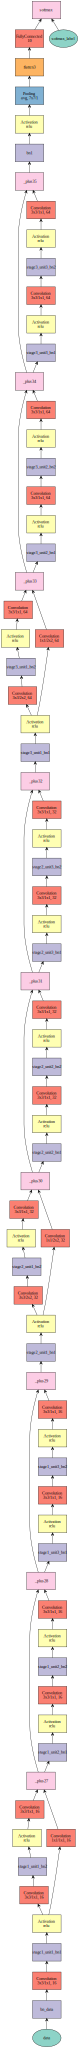

In [20]:
# 2 model getting 
# TODO read through resnet.py file for understanding
def get_resnet():
    net = import_module('resnet')
    sym = net.get_symbol(10,20,"3,28,28")
    return sym 
sym = get_resnet()

# TODO 
# 1. Plot and visualize the network. Put your comments about its architecture (why bottlenet)
# 2. List all weight and output (Question? check MXNET_course/mxnet-week3/cifar10/step_by_step_debug.ipynb)
# Hint: check mx.viz.plot
mx.viz.plot_network(sym)


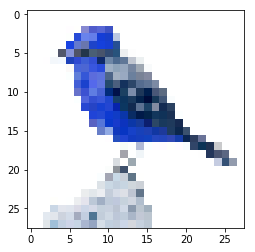

<type 'numpy.ndarray'>
(1, 3, 28, 28)


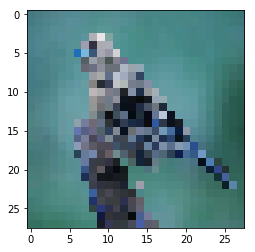

<type 'numpy.ndarray'>
(1, 3, 28, 28)
The very small training dataset contain:  (2, 3, 28, 28)
small dataset is:  <class 'mxnet.io.NDArrayIter'>
DataBatch: data shapes: [(1L, 3L, 28L, 28L)] label shapes: [(1L,)]
DataBatch: data shapes: [(1L, 3L, 28L, 28L)] label shapes: [(1L,)]
[[  9.99999523e-01   4.28651759e-07   4.85202930e-18   2.21805040e-11
    1.61808224e-17   8.77316544e-14   6.52175986e-23   5.15153899e-18
    3.70315014e-24   9.03605801e-11]
 [  9.99916673e-01   7.82801362e-05   1.22231014e-09   1.13433612e-06
    1.72291503e-09   1.97197494e-08   9.25230162e-13   2.95634323e-10
    1.60194083e-13   3.86646343e-06]]


In [40]:
#3 sanity check random image inference
img1 = cv2.imread("bird.jpg")
img1 = cv2.resize(img1,(28,28))
plt.imshow(img1)
plt.show()
print type(img1)
img1 = img1.transpose((2,0,1)).reshape((1,3,28,28))
print img1.shape


img2 = cv2.imread("bird2.jpg")
img2 = cv2.resize(img2,(28,28))# you need to pad it if you do padding for you nework
plt.imshow(img2)
plt.show()
print type(img2)
img2 = img2.transpose((2,0,1)).reshape((1,3,28,28))
print img2.shape

img = np.vstack([img1,img2])
print "The very small training dataset contain: ", img.shape

# TODO: figure out how to convert numpy array to mx.nd.array
img_mxnd = mx.nd.array(ctx=mx.cpu(0), source_array=img) 
label_mxnd = mx.nd.array(ctx=mx.cpu(0), source_array=np.asarray([2,2])) # 6 is frog, give 6 as label
img_itr = mx.io.NDArrayIter(data=img_mxnd, data_name='data', 
                            label_name='softmax_label', label=label_mxnd, 
                            batch_size=1) # ??? Hint the name should "data" and softmax_label
print "small dataset is: ", type(img_itr)
for each in img_itr:
    print each

# TODO bind the random img to network 
# question? check mxnet-week3/cifar10/train_cifar10.py
mod = mx.mod.Module(context=[mx.cpu(0)],
                    symbol=sym,
                    data_names = ['data'],
                    label_names = ['softmax_label']
                   ) 
mod.bind(img_itr.provide_data, img_itr.provide_label)
mod.init_params(mx.init.Xavier(magnitude=2.0))
mod.init_optimizer('sgd', optimizer_params=(('learning_rate', 0.1),))

# # run forward perdiction 
# # TODO fill the mod.predict 
# # check mod.predict
out = mod.predict(eval_data=img_itr, num_batch=-1, reset=True)
print out.asnumpy()

In [42]:
print np.argmax(out.asnumpy(),axis=1)

[0 0]


In [44]:
# 4 overfit small dataset 
# TODO fill all ???
# run forward perdiction
metric = mx.metric.create('acc')

for epoch in range(5):
    img_itr.reset()
    metric.reset()
    for batch in img_itr:
        mod.forward(batch, is_train=True)
        mod.update_metric(metric, batch.label)
        mod.backward()
        mod.update()
    print ('Epoch {}, Train {}'.format(epoch, metric.get()))
    # You should get 100% accuacy on these two images

    


Epoch 0, Train ('accuracy', 1.0)
Epoch 1, Train ('accuracy', 1.0)
Epoch 2, Train ('accuracy', 1.0)
Epoch 3, Train ('accuracy', 1.0)
Epoch 4, Train ('accuracy', 1.0)


In [ ]:
#5 (optional) train cifar10 on resnet(~epoch) if you have GPU. Build the training script from week2
mod_cifar = mx.mod.Module(???)
train.reset()
val.reset()
mod_cifar.fit(train_data=train,
              eval_data=val,
              num_epoch=???,
              optimizer=???, 
              optimizer_params={???}, 
              epoch_end_callback=mx.callback.do_checkpoint('resnet_cifar_10'),
              initializer=mx.init.Xavier(rnd_type='gaussian', factor_type='in',magnitude=2),
              batch_end_callback=[mx.callback.Speedometer(128, 1)], 
              eval_metric=['acc','ce'])

In [ ]:
# 6 (optional) Wild test on your model 